In [1]:
###### Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import networkx as nx  # Import NetworkX for graph operations

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import random
from IPython.display import clear_output
from scipy.special import softmax

from sklearn.utils import shuffle

In [2]:
### Plot 2d for explore data.
def plot_2d_tsne(data_nparray, labels_nparray):
    # Use t-SNE to reduce dimensionality to 2D for visualization
    tsne_embedder = TSNE(n_components=2, perplexity=10, random_state=0)
    embeddings_2d = tsne_embedder.fit_transform(data_nparray)

    plt.figure(figsize=(8, 6))
    colors = plt.cm.get_cmap('tab10')(np.arange(len(np.unique(labels_nparray))))  # Colormap for multiple classes
    for i in range(data_nparray.shape[0]):
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], color=colors[labels_nparray[i]], alpha=0.35)
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

    return embeddings_2d

In [3]:
%run ../utils/trials_v03.py 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", device)

device cuda


In [5]:
# Set Seeds
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
rng = np.random.default_rng(random_seed)

In [6]:
######## Get trial
def get_trial_data(trials_subset_df, episode_trial_index, embedded_stimuli_dict, comps_columns = ["st_comp1","st_comp2","st_comp3"]):
    trial_info = trials_subset_df.iloc[episode_trial_index]
    anchor_key = trial_info.st_sample
    anchor = embedded_stimuli_dict[trial_info.st_sample]
    options_keys = [trial_info[cmp_colum]  for cmp_colum in comps_columns]
    options = [embedded_stimuli_dict[trial_info[cmp_colum]] for cmp_colum in comps_columns]
    positive_index = options_dict[trial_info.option_answer]
    positive_option = trial_info.st_comparison
    return anchor, options, anchor_key, options_keys, positive_index, positive_option

######## Compute Q values
# Compute Q-values for the options using dot product
def compute_q_values(anchor, options, temperature):
    q_values = [dot_product(anchor, option) / temperature for option in options]
    return q_values

######## Select option (action) epsilon
def choose_action (q_values, epsilon):
    # Choose action based on epsilon-greedy policy
    if rng.random() < epsilon:
        # Exploration: choose a random action
        chosen_action = np.random.randint(len(q_values))
    else:
        # Exploitation: choose the action with the highest Q-value
        chosen_action = np.argmax(q_values)
    return chosen_action

######## get response score (reward if correct positive option)
def get_response_score(chosen_action, options, positive_index):
    # Get the chosen option and whether it is the positive example
    chosen_option = options[chosen_action]
    is_positive = (chosen_action == positive_index)
    return chosen_option, is_positive

######## Calculate InfoNCE loss
def dot_product(vec1, vec2):
    """
    Compute the dot product of two vectors.

    Args:
    - vec1 (numpy array): First vector.
    - vec2 (numpy array): Second vector.

    Returns:
    - dot_product (float): Dot product of vec1 and vec2.
    """
    return np.dot(vec1, vec2)

## InfoNCE loss function using log-sum-exp trick for numerical stability
def info_nce_loss(anchor, chosen_option, is_positive, temperature=0.1):
    """
    Calculate the InfoNCE loss between the anchor and the chosen option.

    Args:
    - anchor (numpy array): The anchor embedding.
    - chosen_option (numpy array): The chosen option embedding.
    - is_positive (bool): Whether the chosen option is the positive example.
    - temperature (float): Temperature parameter for scaling.

    Returns:
    - loss (float): Calculated InfoNCE loss.
    """
    # Compute the dot product of anchor and chosen_option, scaled by temperature
    chosen_score = np.dot(anchor, chosen_option) / temperature
    epsln_value = 1e-10  # Small constant to avoid taking log of zero

    if is_positive:
        # For positive example: maximize similarity
        loss = -np.log(1 / (1 + np.exp(-chosen_score)) + epsln_value)
    else:
        # For negative example: minimize similarity
        loss = -np.log(1 - (1 / (1 + np.exp(-chosen_score))) + epsln_value)

    return loss  # Return the calculated loss

######## Compute Gradients
## Gradient computation for InfoNCE loss
def compute_gradients_info_nce(anchor, chosen_option, is_positive, learning_rate=0.01, temperature=0.1):
    """
    Compute the gradients of the InfoNCE loss and update embeddings.

    Args:
    - anchor (numpy array): The anchor embedding.
    - chosen_option (numpy array): The chosen option embedding.
    - is_positive (bool): Whether the chosen option is the positive example.
    - learning_rate (float): Learning rate for updating embeddings.
    - temperature (float): Temperature parameter for scaling.

    Returns:
    - anchor (numpy array): Updated anchor embedding.
    - chosen_option (numpy array): Updated chosen option embedding.
    """
    # Compute the dot product of anchor and chosen_option, scaled by temperature
    chosen_score = np.dot(anchor, chosen_option) / temperature

    if is_positive:
        # Gradient calculation for positive example
        d_chosen = np.exp(chosen_score) / (np.exp(chosen_score) + 1) - 1
    else:
        # Gradient calculation for negative example
        d_chosen = np.exp(chosen_score) / (np.exp(chosen_score) + 1)

    # Compute gradient with respect to the anchor embedding
    anchor_grad = d_chosen * chosen_option
    # Compute gradient with respect to the chosen option embedding
    chosen_option_grad = d_chosen * anchor

    # Update the anchor embedding using gradient descent
    anchor -= learning_rate * anchor_grad
    # Update the chosen option embedding using gradient descent
    chosen_option -= learning_rate * chosen_option_grad

    return anchor, chosen_option  # Return the updated embeddings

######## Update Embeddings
def update_embeddings(embedded_stimuli_dict, anchor_key, anchor_updated, options_keys, chosen_action, chosen_option_updated, is_positive, only_correct_choice):
    if only_correct_choice:
        if is_positive:
            embedded_stimuli_dict[anchor_key] = anchor_updated
            options_keys[chosen_action] = chosen_option_updated
    else:
        embedded_stimuli_dict[anchor_key] = anchor_updated
        options_keys[chosen_action] = chosen_option_updated  


def train_q_network(trials_info_df, embedded_stimuli_dict, n_epochs, learning_rate, temperature, epsilon, only_correct_choice):
    epoch_losses = []
    for epoch in range(n_epochs):
        index_list = np.arange(trials_info_df.shape[0])
        rng.shuffle(index_list)
    
        rewards = []
        for epsd_trial_index in index_list:
            ######## Get trial
            anchor, options, anchor_key, options_keys, positive_index, positive_option = get_trial_data(
                trials_subset_df = trials_info_df, 
                episode_trial_index = epsd_trial_index, 
                embedded_stimuli_dict = embedded_stimuli_dict
            )
            ## Compute Q values
            q_values = compute_q_values(anchor, options, temperature)
            
            ## Select option (action) epsilon
            chosen_action = choose_action (q_values, epsilon)
            
            ## get response score (reward if correct positive option)
            chosen_option, is_positive = get_response_score(chosen_action, options, positive_index)
            
            ## Calculate InfoNCE loss
            loss = info_nce_loss(anchor, chosen_option, is_positive, temperature)
            epoch_losses.append(loss)
            
            ## Compute Gradients
            anchor_updated, chosen_option_updated = compute_gradients_info_nce(anchor, chosen_option, is_positive, learning_rate, temperature)
            
            ## Update Embeddings
            update_embeddings(embedded_stimuli_dict, anchor_key, anchor_updated, options_keys, chosen_action, chosen_option_updated, is_positive, only_correct_choice)
            
            rewards.append(is_positive*1)

        clear_output(wait=True)
        print(f'Epoch {epoch + 1}, Loss: {loss:.4f}')
        plt.plot(range(len(epoch_losses)), 
                 epoch_losses, 
                 alpha = .8,
                 linewidth=.5
                )
        plt.title ("Training Loss")
        plt.xlabel("Episode")
        plt.ylabel("Loss")
        plt.yscale('log')
        plt.show()        

    return embedded_stimuli_dict

In [7]:
def get_evaluation_responses(test_trials_info_df, trained_embedding_stimuli_dict):
    actions_to_options_dict = {0:'O_1', 1:'O_2', 2:'O_3'}
    index_list = np.arange(test_trials_info_df.shape[0])
    
    option_responses = []
    test_rewards = []
    test_losses = []
    q_values_trials = []
    for epsd_trial_index in index_list:
        ######## Get trial
        anchor, options, anchor_key, options_keys, positive_index, positive_option = get_trial_data(
            trials_subset_df = test_trials_info_df, 
            episode_trial_index = epsd_trial_index, 
            embedded_stimuli_dict = trained_embedding_stimuli_dict
        )
        ## Compute Q values
        q_values = compute_q_values(anchor, options, temperature = 1)
        q_values_trials.append(q_values)
        
        ## Select option (action) epsilon
        chosen_action = choose_action (q_values, epsilon=0)
        response_option = actions_to_options_dict[chosen_action]
        option_responses.append(response_option)
        
        ## get response score (reward if correct positive option)
        chosen_option, is_positive = get_response_score(chosen_action, options, positive_index)
        
        ## Calculate InfoNCE loss
        loss = info_nce_loss(anchor, chosen_option, is_positive, temperature = 1)
       
        test_rewards.append(is_positive*1)
        test_losses.append(loss)
    
    softmax_df = pd.DataFrame(
        softmax(np.array(q_values_trials), axis=1), 
        index = test_trials_info_df.index,
        columns = ["opt1_prob","opt2_prob","opt3_prob"]
    )
    
    response_df = pd.DataFrame(
        option_responses, 
        index = test_trials_info_df.index,
        columns = ["agent_response"]
    )
    
    output_info_df = pd.concat([test_trials_info_df, softmax_df, response_df], axis =1)
    output_info_df["response_score"] = (output_info_df["agent_response"]==output_info_df["option_answer"])*1
    output_info_df['sample_member']=[stim[0] for stim in output_info_df.st_sample]
    output_info_df['comparison_member']=[stim[0] for stim in output_info_df.st_comparison]
    
    return output_info_df


In [8]:
##### Create Trials

In [9]:
############################################
    #    Class and members numbers    #
############################################

members_number = 9
classes_number = 4

members_stim, class_stim, stimuli_set, dummy_set = get_stimuli_list(members_n = members_number, classes_n = classes_number)

In [10]:
n_dims = 20
random_stim_keys = stimuli_set+dummy_set
np.random.shuffle(random_stim_keys)
random_vectors = rng.normal(size=(len(random_stim_keys),n_dims))
stims_dict_random = dict(zip(random_stim_keys, random_vectors))

# stimuli_dict_encoded = stims_dict_random # random vector of features

In [11]:
##### Encode Trials
##This encoding can be used in a loop for validate stability across several experiments avoiding learning related to feature encoding positioning. 
stimuli_dict_encoded = encode_stims (stimuli_set, dummy_set) # one-hot encoding embedding

options_dict = {'O_1':0, 'O_2':1, 'O_3':2}

In [12]:
class_labels_nparray = np.array([stm[1] for stm in stimuli_dict_encoded.keys()])
label_to_indx = {label: i for i, label in enumerate(set(class_labels_nparray))}
labels_data = np.array([label_to_indx[lbl_class] for lbl_class in class_labels_nparray])
data_array = np.array(list(stimuli_dict_encoded.values()))

sorted_labels = ["".join([mbr, clss]) for clss in class_stim for mbr in members_stim ] # for plotting

In [13]:
onehot_noise_data = data_array + rng.normal(loc = 0, scale = .01, size = data_array.shape)
# stimuli_dict_encoded = onehot_noise_data # This is for try random vectors as embeddings

<Axes: >

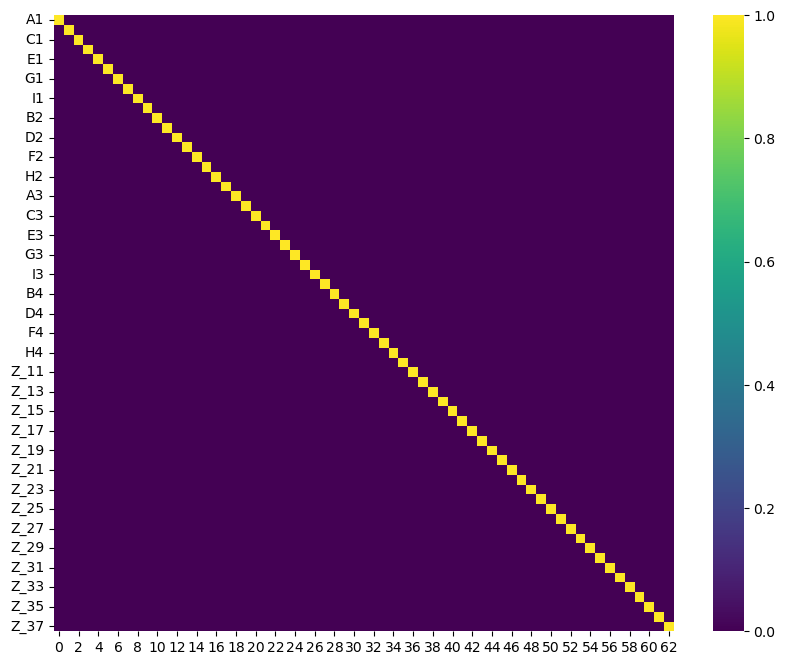

In [14]:
# sns.heatmap(pd.DataFrame(onehot_noise_data).T.sort_index(),
#             cmap= "viridis", #"coolwarm_r",
#            )

##### Initial embedding values

stimuli_dict_encoded_sorted = pd.DataFrame(stimuli_dict_encoded)
stimuli_dict_encoded_sorted.index = stimuli_dict_encoded_sorted.columns
stimuli_dict_encoded_sorted = stimuli_dict_encoded_sorted.loc[sorted_labels+dummy_set, sorted_labels+dummy_set]
stimuli_dict_encoded_sorted.reset_index(drop = True, inplace = True)

plt.figure(figsize=(10,8))

stimuli_dict_encoded
sns.heatmap(stimuli_dict_encoded_sorted.T,
            cmap= "viridis", #"coolwarm_r",
           )

<Axes: >

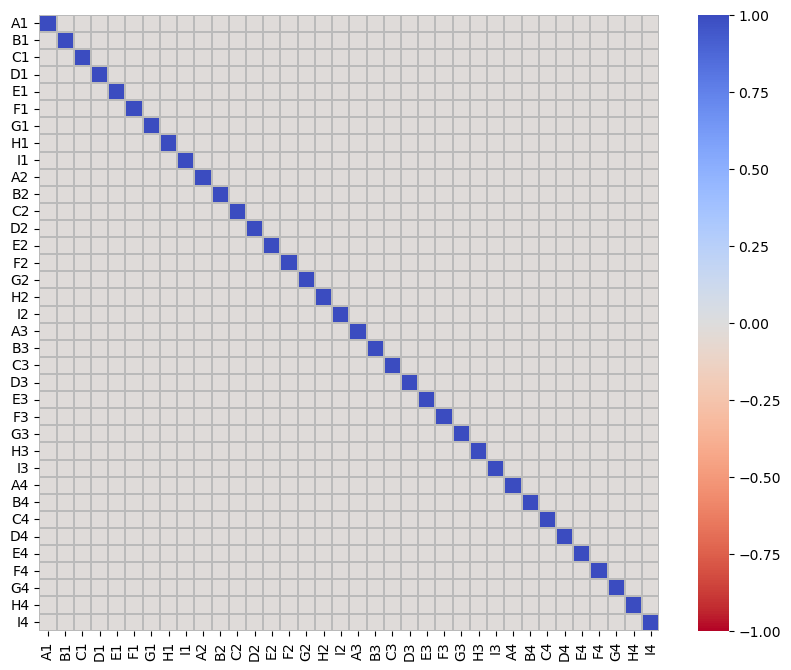

In [15]:
stimuli_embeddings_corr_mat = pd.DataFrame(stimuli_dict_encoded).corr()
plt.figure(figsize=(10,8))#(8,6))#(14,6))#
sns.heatmap(stimuli_embeddings_corr_mat.loc[sorted_labels, sorted_labels],
            cmap="coolwarm_r",
            vmin=-1, vmax=1, 
            center=.0, linewidth=.1, linecolor='#bababa'
           # annot=True, fmt=".1f"
           )

In [16]:
protocols_dict = {f"{ts}_{relation}": {'train_structure': ts, 'relation_type': relation} 
                  for ts in ["LS", "OTM", "MTO"] for relation in ['select_reject', 'select_only']}
list(protocols_dict.keys())

['LS_select_reject',
 'LS_select_only',
 'OTM_select_reject',
 'OTM_select_only',
 'MTO_select_reject',
 'MTO_select_only']

In [17]:
######################
    #    Protocol    #
######################
prt_nm = 1

In [18]:
protocol_names=list(protocols_dict.keys())
print(protocol_names[prt_nm])
protocol = protocols_dict[protocol_names[prt_nm]]
member_pairs_df = create_pair_members(members_stim, train_structure = protocol["train_structure"])
experimental_pairs = create_pairs_classes(member_pairs_df, class_stim)

LS_select_only


In [19]:
baseline_train_trials_info = create_trials(
    subset_to_trials = "baseline", 
    pairs_dataset_df = experimental_pairs, 
    stimuli_list = stimuli_set, 
    dummy_list = dummy_set, 
    relation_type = protocol['relation_type'])

reflexivity_trials_info = create_trials(
    subset_to_trials = "reflexivity", 
    pairs_dataset_df = experimental_pairs, 
    stimuli_list = stimuli_set, 
    dummy_list = dummy_set, 
    relation_type = "select_reject")

symmetry_trials_info = create_trials(
    subset_to_trials = "symmetry", 
    pairs_dataset_df = experimental_pairs, 
    stimuli_list = stimuli_set, 
    dummy_list = dummy_set, 
    relation_type = "select_reject")

transitivity_trials_info = create_trials(
    subset_to_trials = "transitivity", 
    pairs_dataset_df = experimental_pairs, 
    stimuli_list = stimuli_set, 
    dummy_list = dummy_set, 
    relation_type = "select_reject")

In [20]:
# embedded_stimuli_dict = dict(zip(list(stimuli_dict_encoded.keys()),np.array(onehot_noise_data) ))

Epoch 1, Loss: 0.0092


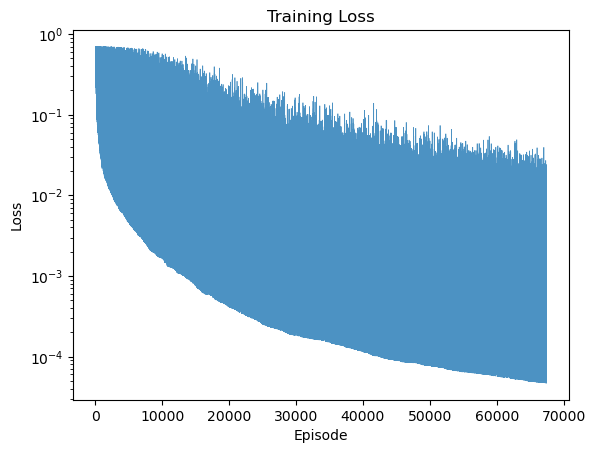

In [21]:
trained_stimuli_embedd_dict = train_q_network(
    trials_info_df = baseline_train_trials_info, 
    embedded_stimuli_dict = dict(zip(list(stimuli_dict_encoded.keys()),np.array(list(stimuli_dict_encoded.values())).astype("float") )), 
    n_epochs = 1, 
    learning_rate = 0.05, 
    temperature = .1, 
    epsilon = .15,
    only_correct_choice = False
)
##
## Protocol LS_select_reject, only_correct_choice = False, Around epoch 19 loss drops abruptly

In [22]:
output_embeddings = pd.DataFrame(trained_stimuli_embedd_dict)
output_embeddings_corr_mat = output_embeddings.corr()

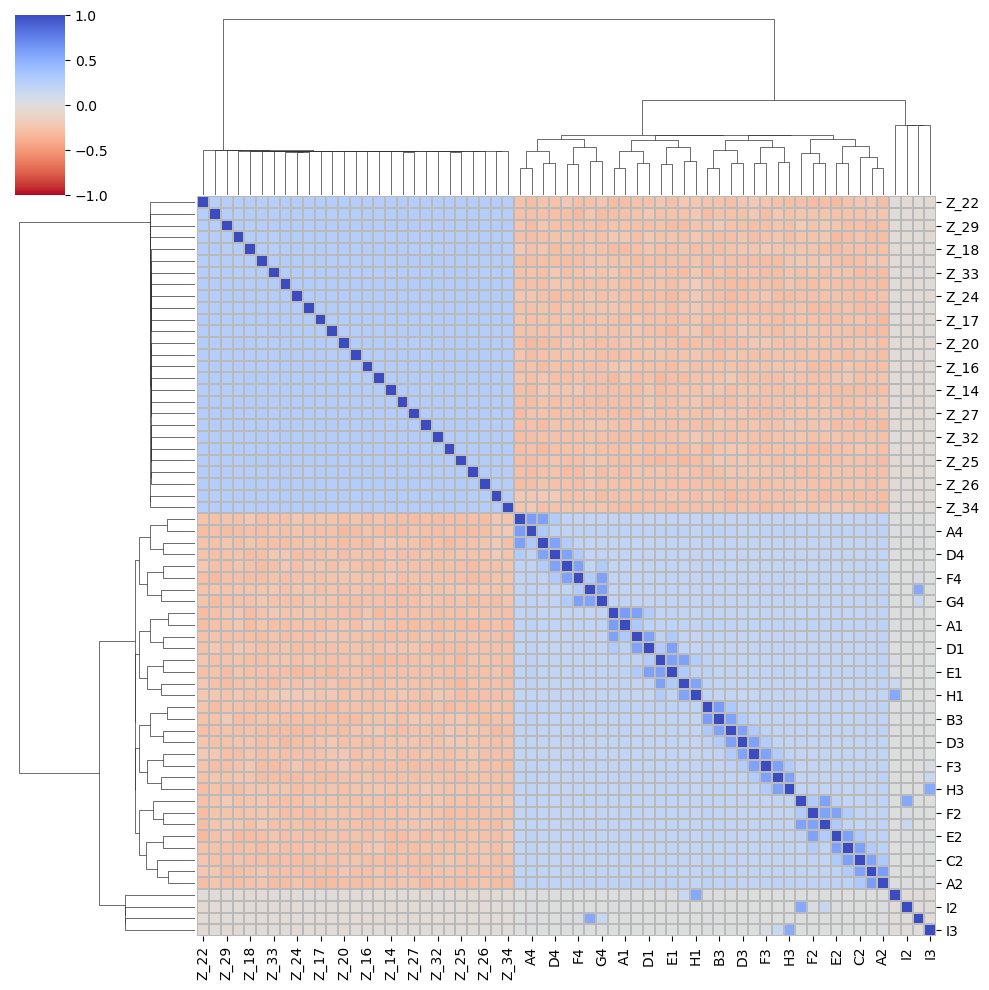

In [23]:
sns.clustermap(output_embeddings_corr_mat, 
               # cmap="viridis",
               cmap="coolwarm_r", vmin=-1, vmax=1, center=.0, linewidth=.1, linecolor='#bababa'
              )

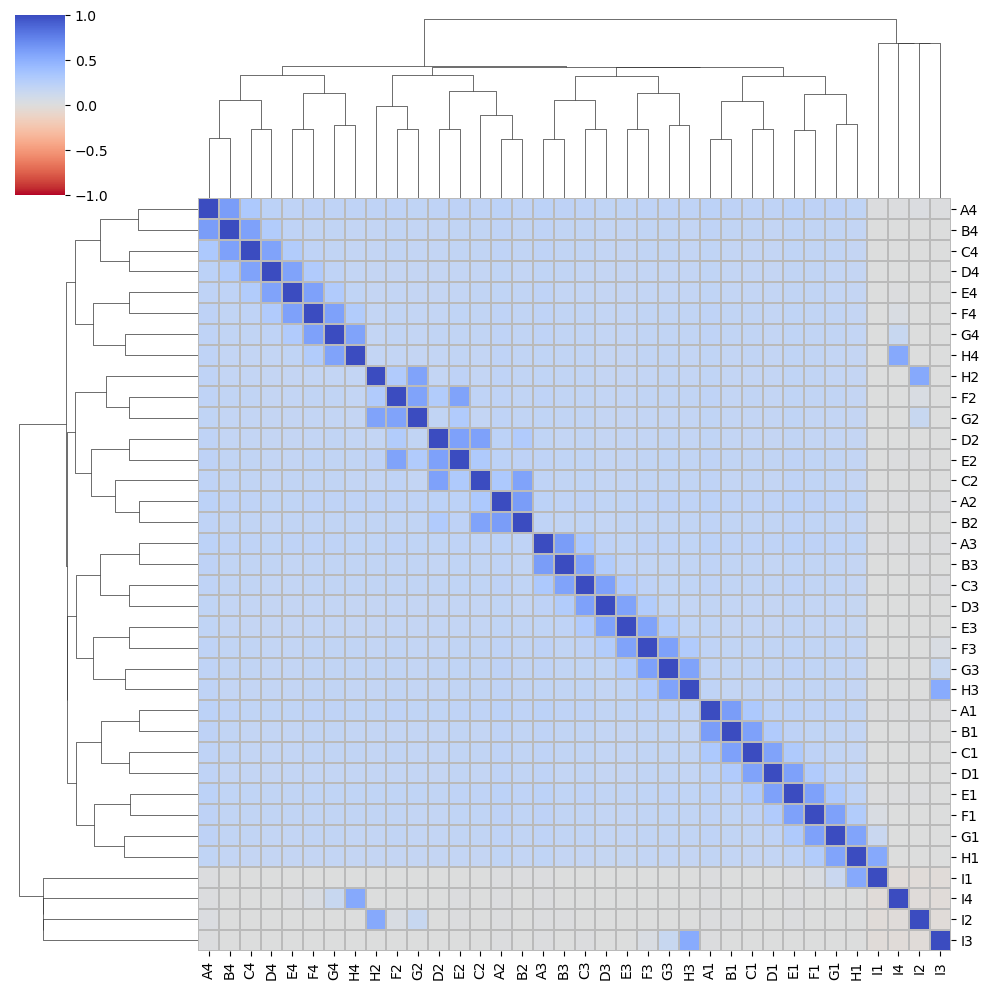

In [24]:
sns.clustermap(output_embeddings_corr_mat.loc[sorted_labels, sorted_labels],
               # cmap="viridis",
               cmap="coolwarm_r", vmin=-1, vmax=1, center=.0, linewidth=.1, linecolor='#bababa'
              )

<Axes: >

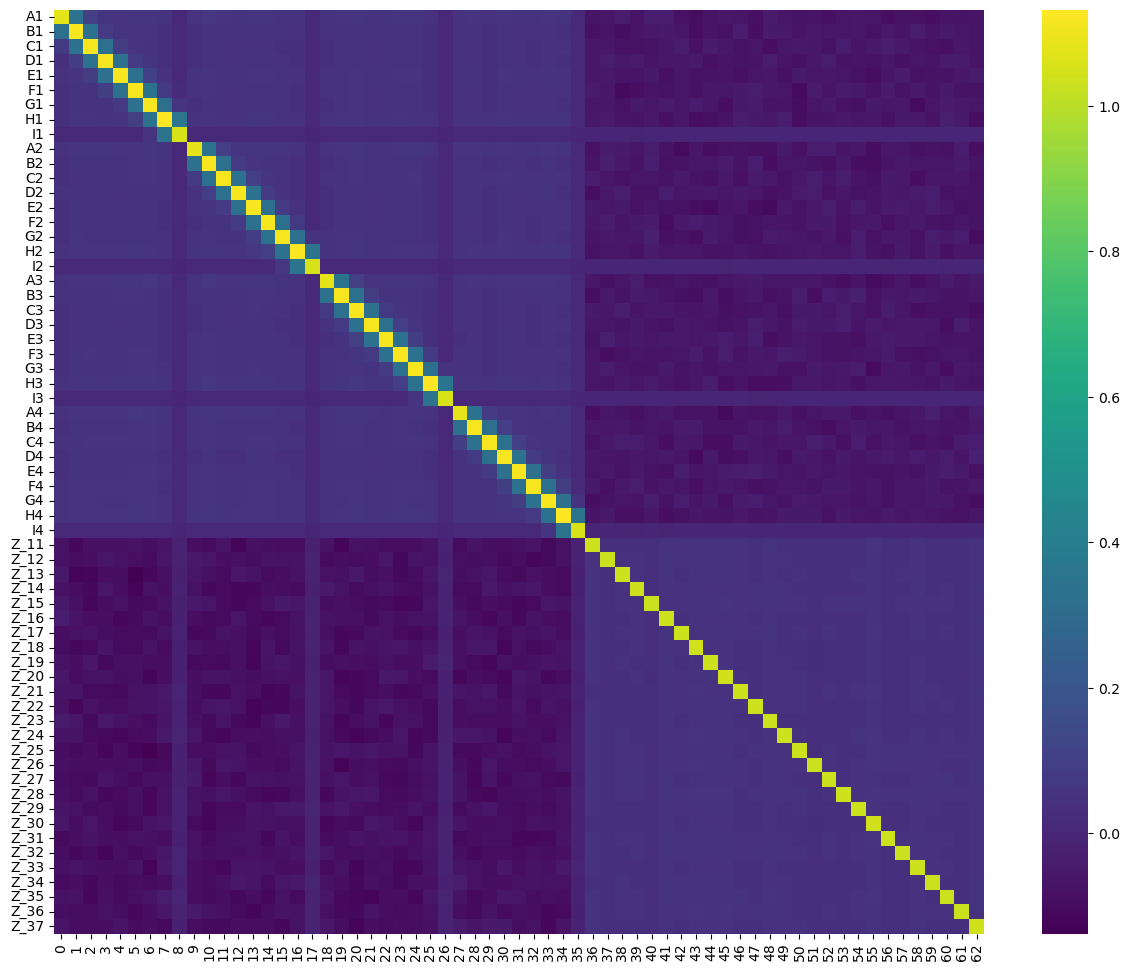

In [25]:
# stimuli_dict_encoded
embeddings_out_sorted = pd.DataFrame(trained_stimuli_embedd_dict)
embeddings_out_sorted.index = embeddings_out_sorted.columns
embeddings_out_sorted = embeddings_out_sorted.loc[sorted_labels+dummy_set, sorted_labels+dummy_set]
embeddings_out_sorted.reset_index(drop = True, inplace = True)

plt.figure(figsize=(15,12))
# plt.imshow(embeddings_out_sorted.T, cmap="viridis")

sns.heatmap(embeddings_out_sorted.T,
            cmap= "viridis", #"coolwarm_r",
            # vmin=-1, vmax=1, 
            # center=.0, 
            # linewidth=.1, linecolor='#bababa',
           # annot=True, fmt=".1f"
           )

<Axes: >

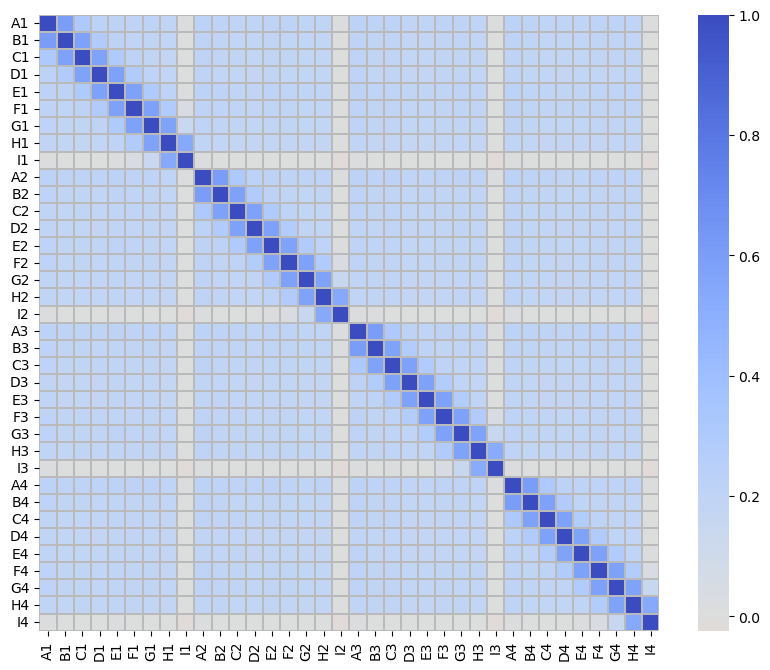

In [26]:
plt.figure(figsize=(10,8))#(8,6))#(14,6))#
sns.heatmap(output_embeddings_corr_mat.loc[sorted_labels, sorted_labels],
            cmap="coolwarm_r",
            # vmin=-1, vmax=1, 
            center=.0, linewidth=.1, linecolor='#bababa'
           # annot=True, fmt=".1f"
           )

<Axes: >

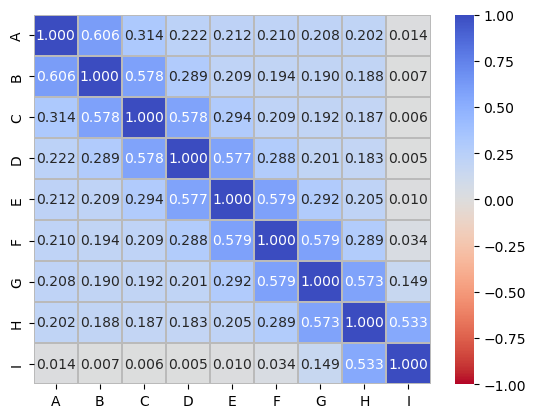

In [27]:
avg_relations = pd.DataFrame(np.zeros((members_number,members_number)),index= members_stim, columns = members_stim)
for class_nmbr in class_stim:
    class_labels = [mmbr+class_nmbr for mmbr in members_stim]
    class_relations = output_embeddings_corr_mat.loc[class_labels,class_labels]#sorted_labels, sorted_labels]
    class_relations.index = members_stim
    class_relations.columns = members_stim
    avg_relations += class_relations/classes_number 

sns.heatmap(avg_relations,
            cmap="coolwarm_r",
            vmin=-1, vmax=1, 
            center=.0, linewidth=.1, linecolor='#bababa',
           annot=True, fmt=".3f"
           )

In [28]:
stim_dict_keys_sorted=sorted_labels+dummy_set
dot_mat_vals = []
for st_sample_key in stim_dict_keys_sorted:
    for st_comparison_key in stim_dict_keys_sorted:
        dot_product_val = np.dot(
            trained_stimuli_embedd_dict[st_sample_key],
            trained_stimuli_embedd_dict[st_comparison_key]
        )
        dot_mat_vals.append([st_sample_key,st_comparison_key,dot_product_val])
dot_mat_df = pd.DataFrame(dot_mat_vals, columns= ["st_sample", "st_comparison", "dot_product"]).pivot(index="st_sample", columns="st_comparison", values="dot_product")
dot_mat_df = dot_mat_df.loc[stim_dict_keys_sorted,stim_dict_keys_sorted]

<Axes: xlabel='st_comparison', ylabel='st_sample'>

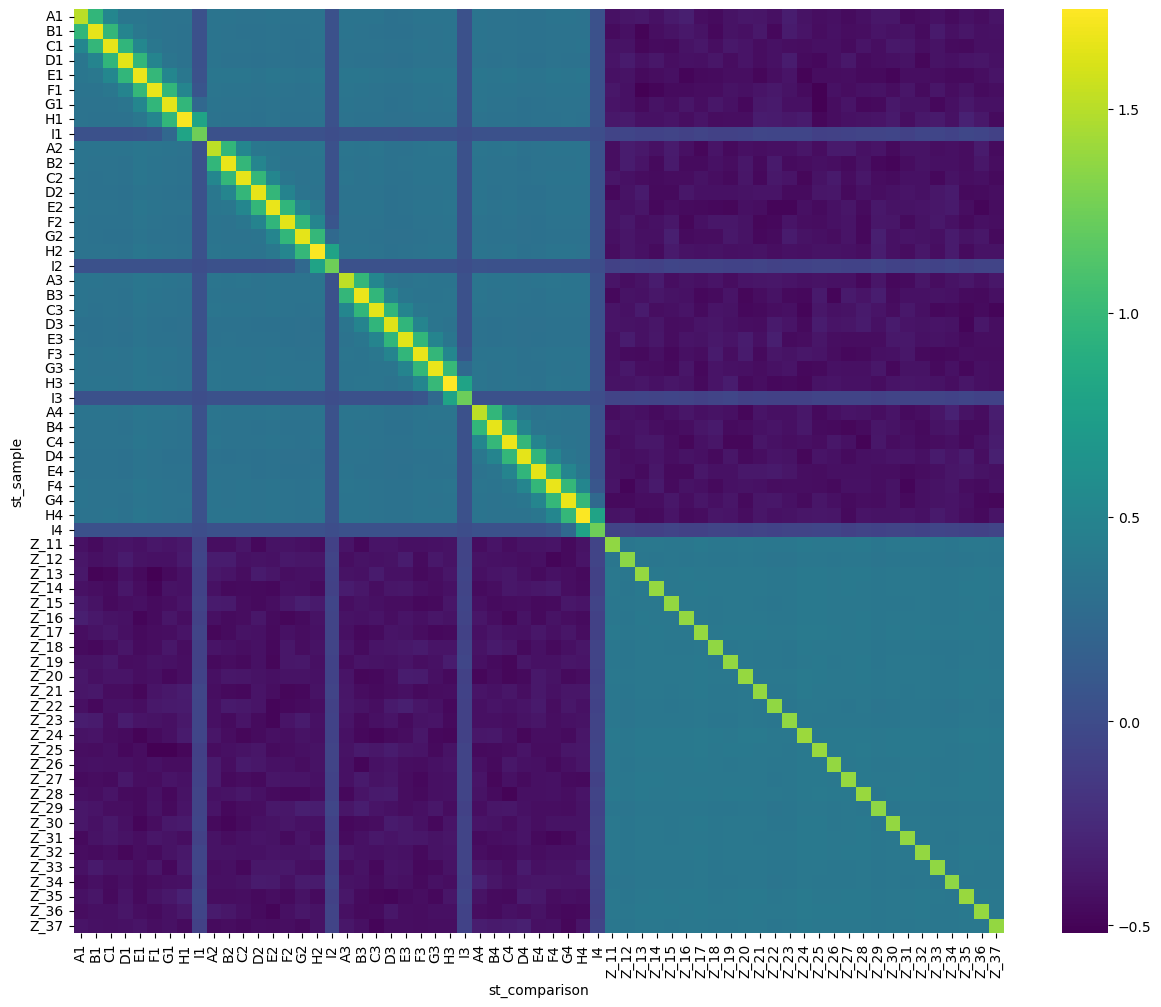

In [29]:
plt.figure(figsize=(15,12))
sns.heatmap(dot_mat_df,
            cmap= "viridis", #"coolwarm_r",
            # vmin=-1, vmax=1, 
            # center=.0, 
            # linewidth=.1, linecolor='#bababa',
           # annot=True, fmt=".1f"
           )

<Axes: xlabel='st_comparison', ylabel='st_sample'>

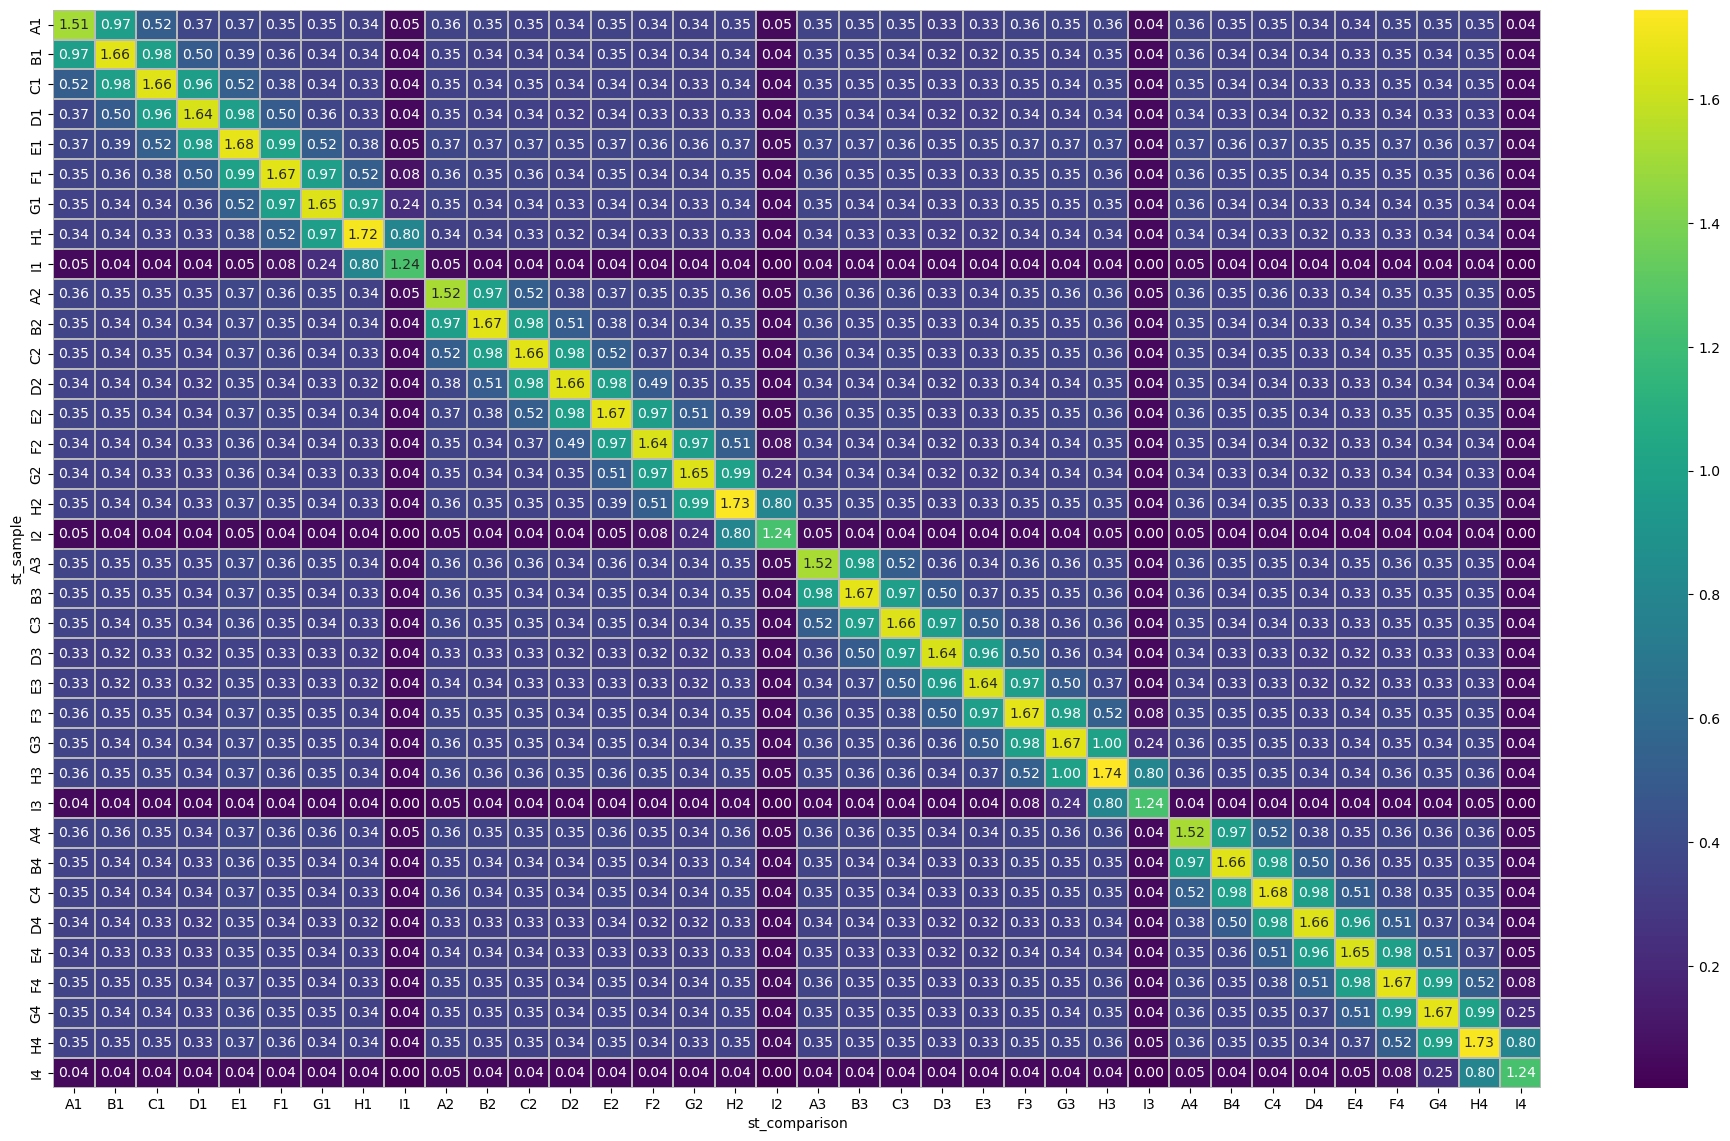

In [30]:
plt.figure(figsize=(24,14))
sns.heatmap(dot_mat_df.loc[sorted_labels, sorted_labels],
            cmap= "viridis", #"coolwarm_r",
            # vmin=-1, vmax=1, 
            # center=.0, 
            linewidth=.1, linecolor='#bababa',
           annot=True, fmt=".2f"
           )

<Axes: >

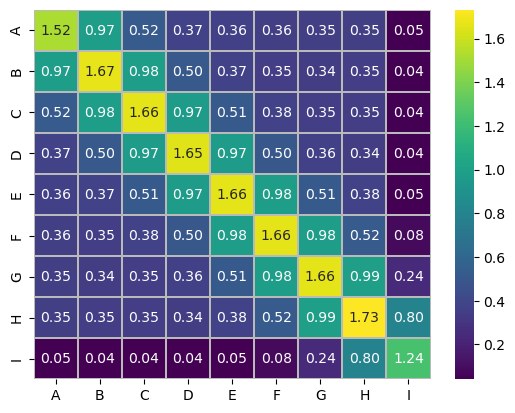

In [31]:
avg_dot_product = pd.DataFrame(np.zeros((members_number,members_number)),index= members_stim, columns = members_stim)
for class_nmbr in class_stim:
    class_labels = [mmbr+class_nmbr for mmbr in members_stim]
    class_relations = dot_mat_df.loc[class_labels,class_labels]#sorted_labels, sorted_labels]
    class_relations.index = members_stim
    class_relations.columns = members_stim
    avg_dot_product += class_relations/classes_number 

sns.heatmap(avg_dot_product,
            cmap="viridis",
            # vmin=-1, vmax=1, center=.0, 
            linewidth=.1, linecolor='#bababa',
            annot=True, fmt=".2f"
           )

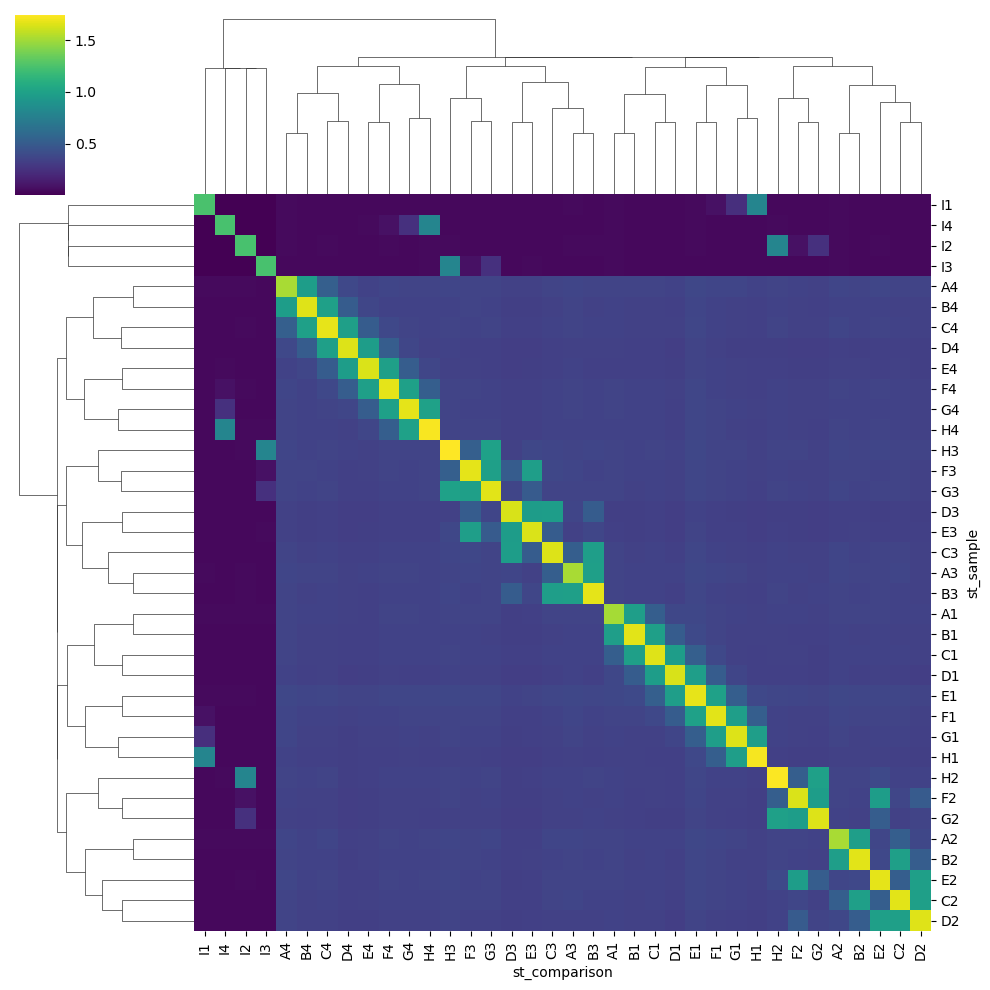

In [32]:
sns.clustermap(dot_mat_df.loc[sorted_labels, sorted_labels], 
               cmap="viridis", # cmap="coolwarm_r", 
               # vmin=-1, vmax=1, center=.0, 
               # linewidth=.1, linecolor='#bababa'
              )

In [33]:
baseline_train_responses_df = get_evaluation_responses(test_trials_info_df = baseline_train_trials_info, trained_embedding_stimuli_dict = trained_stimuli_embedd_dict)
reflexivity_responses_df = get_evaluation_responses(test_trials_info_df = reflexivity_trials_info, trained_embedding_stimuli_dict = trained_stimuli_embedd_dict)
symmetry_responses_df = get_evaluation_responses(test_trials_info_df = symmetry_trials_info, trained_embedding_stimuli_dict = trained_stimuli_embedd_dict)
transitivity_responses_df = get_evaluation_responses(test_trials_info_df = transitivity_trials_info, trained_embedding_stimuli_dict = trained_stimuli_embedd_dict)


In [34]:
protocol_output = pd.concat([
    baseline_train_responses_df,
    reflexivity_responses_df,
    symmetry_responses_df,
    transitivity_responses_df],
    axis=0, 
    ignore_index=True)

In [35]:
### SAVE protocol output
# protocol_output.to_pickle("salidas/"+protocol_names[prt_nm]+".pkl")

In [36]:
%run ../utils/results_explore.py

<Figure size 640x480 with 0 Axes>

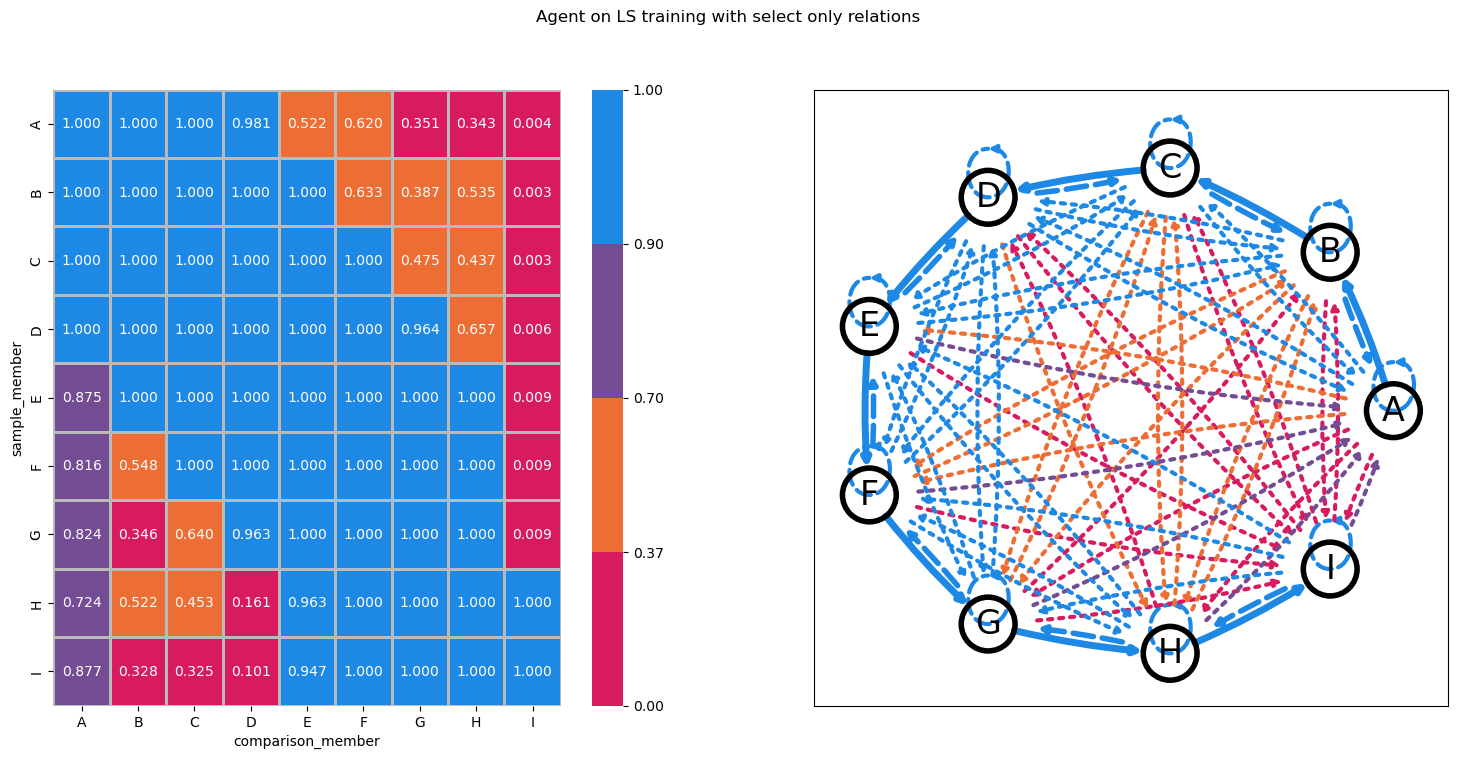

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [37]:
random_limit = .37
prtcl_mn = protocol_names[prt_nm]


protocol_output.loc[protocol_output.sample_subset=="baseline", "sample_subset"]="train"
evaluation_graph_dat = get_agent_graph_dat(
    agent_info_df = protocol_output, 
    metric_column = "response_score"
)
evaluation_graph_dat.response_score = evaluation_graph_dat.response_score.astype("float")

fig, all_axes = plt.subplots(1, 2, figsize=(18, 8))
axs = all_axes.flat

fig.suptitle(' '.join([
    "Agent on",
    protocols_dict[prtcl_mn]['train_structure'], "training with", 
    (protocols_dict[prtcl_mn]['relation_type']).replace("_", " "), "relations"
]))
heatmap_out=plot_heatmap_dat(
    graph_dat_plot=evaluation_graph_dat, 
    metric_column="response_score", 
    minimal_cut_value=.9,
    random_level=random_limit,
    ax_plot = axs[0]
)

plot_graph_results(
    graph_dat_plot=evaluation_graph_dat,
    metric_column="response_score",
    node_origin="sample_member",
    node_destiny="comparison_member",
    trial_group="sample_subset",
    minimal_cut_value=.9,
    random_level=random_limit,
    ax_plot = axs[1]
)

### SAVE Plot
# fig.savefig("salidas/"+prtcl_mn+"_output_embedded.pdf")